# Transformer Data Pipeline and Predictive Analysis

## Data Pipeline  
- Data ingestion from Supabase and Open-Meteo API (via transformer-weather-ingest: https://github.com/stephengilbert1/transformer-weather-ingest)  
- Data cleaning and integration

## Exploratory Data Analysis  
- Visualization of internal and ambient temperatures  
- Correlation analysis

## Predictive Modeling  
- Linear regression and forecasting transformer temperature  
- Model evaluation and applications

# Setup and Imports

- Load libraries, environment variables, and configure plot styles

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import json


from datetime import datetime, timedelta, timezone
from pathlib import Path
from supabase import create_client
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

load_dotenv()


SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_SERVICE_ROLE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

### Style defaults for consistency with portfolio

In [2]:


def set_plot_styles():
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Outfit", "Arial", "Helvetica", "DejaVu Sans"]
    plt.rcParams["figure.facecolor"] = "#ffffff"
    plt.rcParams["axes.facecolor"] = "#ffffff"
    plt.rcParams["text.color"] = "#171717"
    plt.rcParams["axes.labelcolor"] = "#171717"
    plt.rcParams["xtick.color"] = "#171717"
    plt.rcParams["ytick.color"] = "#171717"

set_plot_styles()

## Data Loading

This function will load the latest 30 days of transformer temperature readings and ambient temperature data from Supabase.   
- Transformer temperature data is generated by a vercel triggered cron job. This data is shared by the Transformer Dashboard application.
- Ambient temperature data is obtained via the transformer-weather-ingest tool from Open-Meteo API. 
- The database will likely have stale or missing ambient temperature data unless this tool has been executed recently.

In [3]:
def fetch_readings_from_supabase(days: int = 30, page_size: int = 1000, max_rows: int | None = None):
    client = create_client(SUPABASE_URL, SUPABASE_SERVICE_ROLE_KEY)
    since = (datetime.now(timezone.utc) - timedelta(days=days))\
        .isoformat(timespec="seconds").replace("+00:00", "Z")

    rows, offset = [], 0
    while True:
        q = (
            client.table("temperature_readings")      # or .postgrest.from_(...)
                  .select("transformer_id,timestamp,tempC, ambient_temperature")
                  .gte("timestamp", since)
                  .order("timestamp", desc=False)
                  .range(offset, offset + page_size - 1)
        )
        try:
            res = q.execute()
        except Exception as e:
            raise RuntimeError(f"Supabase fetch failed: {e}") from e

        batch = res.data or []
        rows.extend(batch)

        # stop conditions
        if len(batch) < page_size:
            break
        offset += page_size
        if max_rows and len(rows) >= max_rows:
            rows = rows[:max_rows]
            break

    return rows

DATA_PATH = Path("../data/readings.csv")
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True)
OVERHEAT_THRESHOLD = float(os.getenv("OVERHEAT_THRESHOLD", "100"))

rows = fetch_readings_from_supabase(days=30, page_size=1000, max_rows=100000)
df = pd.DataFrame(rows)

## Data Cleaning and Preprocessing

- Convert timestamps to datetime format 
- Print basic info about the fetched data 
- Clean data by removing rows with missing temperature values


In [4]:


# Parse timestamp, coerce errors to NaT
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

print("Fetched rows:", len(df))
print("time span:", df["timestamp"].min(), "→", df["timestamp"].max(), f"({len(df)} rows)")

# Drop rows where parsing of timestamp failed
num_bad_timestamps = df["timestamp"].isna().sum()
if num_bad_timestamps > 0:
    print(f"Dropping {num_bad_timestamps} rows with invalid timestamps")
df = df.dropna(subset=["timestamp"])

# Drop duplicate rows based on timestamp + temp columns (if duplicate readings exist)
num_duplicates = df.duplicated(subset=["timestamp", "tempC", "ambient_temperature"]).sum()
if num_duplicates > 0:
    print(f"Dropping {num_duplicates} duplicate rows")
df = df.drop_duplicates(subset=["timestamp", "tempC", "ambient_temperature"])

# Drop rows missing critical temperature data
df = df.dropna(subset=["tempC", "ambient_temperature"])

# Sort and reset index
df = df.sort_values("timestamp").reset_index(drop=True)

print(df[["tempC", "ambient_temperature"]].describe())
df.head()

Fetched rows: 19575
time span: 2025-08-05 19:00:00+00:00 → 2025-09-04 23:00:00+00:00 (19575 rows)
Dropping 70 duplicate rows
             tempC  ambient_temperature
count  7241.000000          7241.000000
mean     80.134840            19.173926
std      15.302885             3.425946
min      48.640000            11.600000
25%      67.110000            16.500000
50%      80.370000            18.800000
75%      92.990000            21.200000
max     111.160000            29.800000


,transformer_id,timestamp,tempC,ambient_temperature
0,XFMR-0009,2025-08-05 19:00:00+00:00,84.19,19.1
1,XFMR-0005,2025-08-05 19:00:00+00:00,98.28,19.1
2,XFMR-0003,2025-08-05 19:00:00+00:00,87.24,19.7
3,XFMR-0001,2025-08-05 19:00:00+00:00,92.74,19.2
4,XFMR-0004,2025-08-05 19:00:00+00:00,95.56,19.1


## Exploratory Data Analysis (EDA)

### Time Series for a Single Transformer

We select one transformer and prepare its temperature data over time. The purpose of this is to gain an initial understanding into the transformer temperature behaviour.
A 6-hour rolling average is computed to smooth short-term fluctuations and see if any patterns in the behaviour become more obvious.


In [5]:
t_id = df["transformer_id"].iloc[0]
df_one = df[df["transformer_id"] == t_id].copy().sort_values("timestamp")
df_one["rolling_6h"] = df_one["tempC"].rolling(window=6, min_periods=1).mean()

### Visualizing Transformer Temperature Trends

We plot the raw top-oil temperature and the 6-hour rolling average over time for the selected transformer, highlighting overall trends.


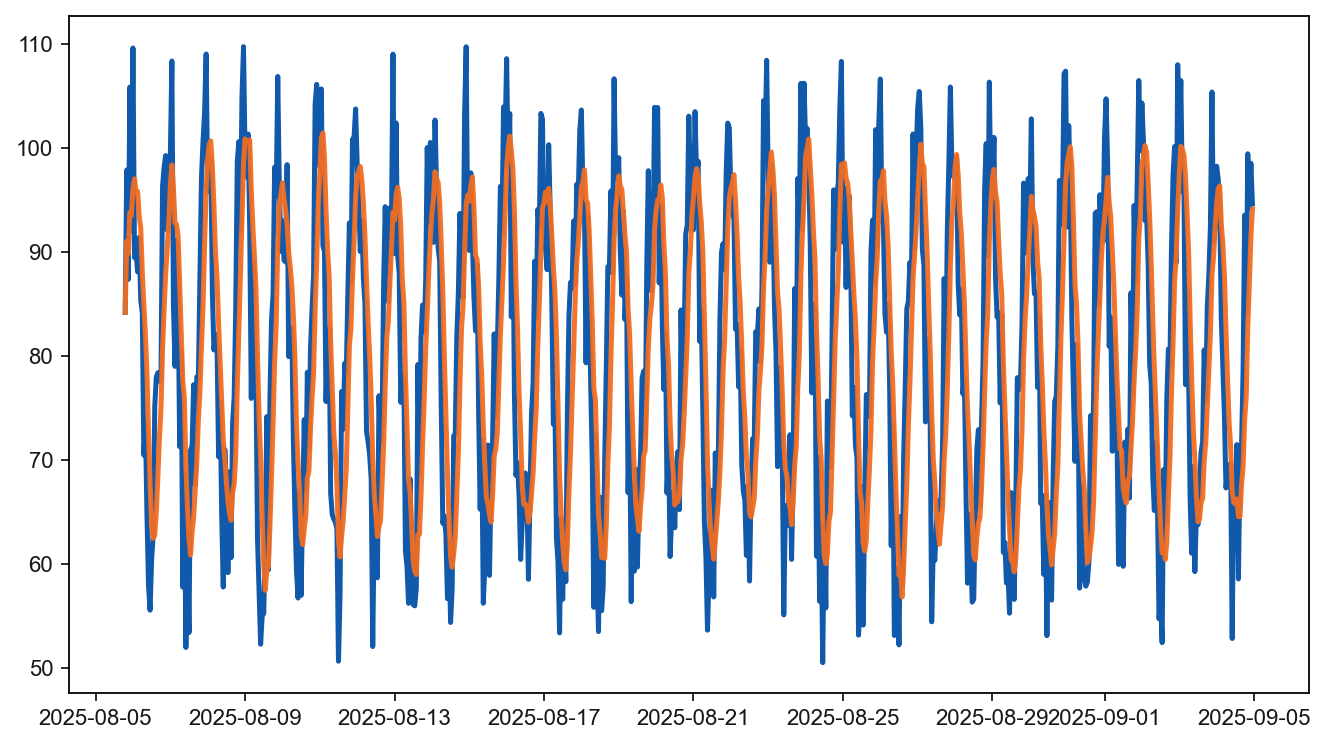

In [6]:
fig, ax = plt.subplots(figsize=(10, 5.5), dpi=160)

# Main series
ax.plot(df_one["timestamp"], df_one["tempC"], linewidth=2.25,
        label=f"{t_id} Top-Oil", color="#1059ab")

# Rolling average
ax.plot(df_one["timestamp"], df_one["rolling_6h"], linewidth=2.25,
        label="6-hr avg", color="#f26d21", alpha=0.95)

### Oil Temperature Rise Above Ambient

A key metric in transformer health monitoring is the oil temperature rise above the ambient temperature. This value helps isolate the temperature increase caused by transformer load and internal heat generation from the influence of surrounding environmental conditions.

By calculating temperature rise, we can better identify transformers experiencing abnormal heating patterns that may indicate thermal overload or emerging faults. This metric is also valuable for setting more meaningful thresholds and improving model features.

Below, we calculate this metric, provide summary statistics, and flag instances where the temperature rise exceeds a chosen critical threshold.


In [7]:
# Calculate oil temperature rise above ambient
df['temp_rise'] = df['tempC'] - df['ambient_temperature']

# Basic stats on temperature rise
print("Temperature rise above ambient:")
print(df['temp_rise'].describe())

# Example: flag rows where rise exceeds a threshold (e.g., 65°C)
threshold = 65
df['over_temp_rise'] = df['temp_rise'] > threshold
print(f"Number of readings with temperature rise > {threshold}°C:", df['over_temp_rise'].sum())


Temperature rise above ambient:
count    7241.000000
mean       60.960914
std        13.159383
min        30.840000
25%        50.320000
50%        61.280000
75%        71.490000
max        92.530000
Name: temp_rise, dtype: float64
Number of readings with temperature rise > 65°C: 2959


## Linear Regression Modeling

### Approach

- We use a simple linear regression model to predict transformer internal temperature (`tempC`) based on ambient temperature.  
- This model will help us understand the relationship between ambient and internal temperatures and evaluate how well ambient temperature alone can explain internal temperature variations.
- This initial model serves as a baseline to evaluate whether ambient temperature can reasonably predict the internal temperature variation. Its performance metrics and visualizations will guide future extensions, such as incorporating additional features or more advanced time series models.
- The following code prepares the predictor and response variables, fits the linear regression model, generates predictions, and evaluates the model’s fit. 

### Model Training and Evaluation Strategy
To ensure our model generalizes well to new, unseen data, we split the dataset into training and test sets. The training set is used to fit (train) the linear regression model, while the test set evaluates its predictive performance. This helps prevent overfitting and gives a realistic estimate of how well ambient temperature alone predicts internal transformer temperature.

### How to Interpret the Plots
#### Actual vs. Predicted Plot:
This scatter plot shows true internal temperatures (points) against their corresponding model predictions (red line). Points clustered closely around the red regression line indicate good predictive accuracy.

#### Residual Plot:
This plot displays the difference between actual and predicted temperatures (residuals) versus ambient temperature. Ideally, residuals should be randomly scattered around zero without patterns, indicating unbiased predictions. Systematic trends or large residuals suggest areas where the model may be improved.


In [ ]:
def train_and_evaluate_linear_regression_html(df, output_prefix="linear_regression"):
    
    X = df[['ambient_temperature']].values
    y = df['tempC'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    df['predicted_tempC'] = model.predict(X)

    # Metrics printout
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Slope: {model.coef_[0]:.3f}, Intercept: {model.intercept_:.3f}")
    print(f"R^2: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")
    print(f"Model: internal_temperature = {model.intercept_:.3f} + {model.coef_[0]:.3f} * ambient_temperature")

    # --- Plot 1: Actual vs Predicted ---
    sorted_idx = X_test.flatten().argsort()
    X_test_sorted = X_test[sorted_idx]
    y_test_sorted = y_test[sorted_idx]
    y_pred_sorted = y_pred[sorted_idx]

    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.scatter(X_test_sorted, y_test_sorted, alpha=0.5, label='Actual')
    ax1.plot(X_test_sorted, y_pred_sorted, color='red', linewidth=2, label='Predicted')
    ax1.set_xlabel('Ambient Temperature (°C)')
    ax1.set_ylabel('Internal Transformer Temp (°C)')
    ax1.set_title('Linear Regression: Actual vs Predicted (Test Set)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.set_xlim(X_test.min() - 1, X_test.max() + 1)
    ax1.set_ylim(min(y_test.min(), y_pred.min()) - 1, max(y_test.max(), y_pred.max()) + 1)

    responsive_css = """
    <style>
      html, body {
        margin:0; padding:0; width:100%; height:100%; overflow:hidden;
      }
      .mpld3-figure {
        width:100% !important; height:100% !important; overflow:hidden !important;
      }
      svg {
        width:100% !important; height:100% !important; display:block; overflow:visible !important;
      }
    </style>
    """

    html_str1 = mpld3.fig_to_html(fig1, template_type='simple')
    html_str1 = html_str1.replace("<head>", "<head>" + responsive_css)
    with open(f"{OUT_DIR / f'{output_prefix}_actual_vs_predicted.html'}", "w") as f:
        f.write(html_str1)
    plt.close(fig1)

    # --- Plot 2: Residual Plot ---
    residuals = y_test - y_pred
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.scatter(X_test, residuals, alpha=0.5)
    ax2.plot([X_test.min()-1, X_test.max()+1], [0,0], color='red', linestyle='--', linewidth=2)
    ax2.set_xlim(X_test.min() - 1, X_test.max() + 1)
    ax2.set_ylim(residuals.min() - 1, residuals.max() + 1)
    ax2.set_xlabel('Ambient Temperature (°C)')
    ax2.set_ylabel('Residuals (Actual - Predicted)')
    ax2.set_title('Residual Plot (Test Set)')
    ax2.grid(True, linestyle='--', alpha=0.6)

    fig2.tight_layout()

    html_str2 = mpld3.fig_to_html(fig2, template_type='simple')
    html_str2 = html_str2.replace("<head>", "<head>" + responsive_css)
    with open(f"{OUT_DIR / f'{output_prefix}_residuals.html'}", "w") as f:
        f.write(html_str2)
    plt.close(fig2)

# Usage
train_and_evaluate_linear_regression_html(df)


Slope: 3.083, Intercept: 20.969
R^2: 0.458, MAE: 9.091, RMSE: 11.141
Model: internal_temperature = 20.969 + 3.083 * ambient_temperature


### Summary Statistics per Transformer

First, we ensure transformer IDs are strings for consistency.  
Then, we compute key summary statistics per transformer, including average and maximum internal temperatures, and the count of temperature readings.


In [9]:
# --- Ensure IDs are strings BEFORE any groupbys/joins ---
df["transformer_id"] = df["transformer_id"].astype(str)

# 1) Summary per transformer (avg/max/count)
summary = (
    df.groupby("transformer_id", as_index=True)
      .agg(
          avg_temp=("tempC", "mean"),
          max_temp=("tempC", "max"),
          count=("tempC", "size"),
      )
      .round(2)
)
summary.head()

,avg_temp,max_temp,count
transformer_id,,,
XFMR-0001,80.30,109.93,724
XFMR-0002,80.14,110.98,724
XFMR-0003,80.25,109.47,724
XFMR-0004,80.30,110.21,724
XFMR-0005,80.23,108.81,724


### Calculating Hours Above Threshold

We define a helper function using linear interpolation to calculate the number of hours each transformer’s temperature stayed above the defined overheating threshold within a specified time window.


In [10]:
def hours_over_threshold_window(g: pd.DataFrame, thresh: float,
                                start: pd.Timestamp, end: pd.Timestamp) -> float:
    s = g[["timestamp", "tempC"]].dropna().sort_values("timestamp")
    if len(s) < 2:
        return 0.0
    t0 = s["timestamp"].astype("int64").to_numpy() / 1e9
    t1 = s["timestamp"].shift(-1).astype("int64").to_numpy() / 1e9
    y0 = s["tempC"].to_numpy(dtype=float)
    y1 = s["tempC"].shift(-1).to_numpy(dtype=float)
    mask = ~np.isnan(t1)
    t0, t1, y0, y1 = t0[mask], t1[mask], y0[mask], y1[mask]
    if t0.size == 0:
        return 0.0

    start_s = start.value / 1e9
    end_s   = end.value   / 1e9
    sel = (t1 > start_s) & (t0 < end_s)
    if not np.any(sel):
        return 0.0
    t0, t1, y0, y1 = t0[sel], t1[sel], y0[sel], y1[sel]
    ts = np.maximum(t0, start_s)
    te = np.minimum(t1, end_s)

    denom = (t1 - t0)
    denom[denom == 0.0] = np.nan
    m = (y1 - y0) / denom  # °C/s

    above_ms = np.zeros_like(ts)

    both_above = (y0 > thresh) & (y1 > thresh)
    above_ms[both_above] = (te[both_above] - ts[both_above]) * 1000

    crossing = ((y0 > thresh) ^ (y1 > thresh)) & np.isfinite(m)
    if np.any(crossing):
        t_cross = t0[crossing] + (thresh - y0[crossing]) / m[crossing]
        falling = (y0[crossing] > thresh) & (y1[crossing] <= thresh)
        rising  = ~falling
        t_left  = np.maximum(ts[crossing], t_cross)
        t_right = np.minimum(te[crossing], t_cross)
        above_ms[crossing][falling] += np.maximum(0, (t_right[falling] - ts[crossing][falling]) * 1000)
        above_ms[crossing][rising]  += np.maximum(0, (te[crossing][rising] - t_left[rising]) * 1000)

    return float(above_ms.sum() / 3_600_000.0)  # ms -> hours


### Hours Over Temperature Threshold Across Time Windows

Using the function above, we compute how many hours each transformer’s temperature exceeded the overheating threshold in the last 24 hours, 7 days, and 30 days.


In [11]:
now_utc   = pd.Timestamp.now(tz="UTC")
start_24h = now_utc - pd.Timedelta(hours=24)
start_7d  = now_utc - pd.Timedelta(days=7)
start_30d = now_utc - pd.Timedelta(days=30)

over_24h = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_24h, now_utc))
      .rename("hours_over_thresh_24h")
)
over_7d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_7d,  now_utc))
      .rename("hours_over_thresh_7d")
)
over_30d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_30d, now_utc))
      .rename("hours_over_thresh_30d")
)

### Combined Risk Summary and Export

We join the summary statistics with the hours-over-threshold metrics to create a comprehensive risk table.  
This table is saved as a CSV file for further reporting and analysis.


In [12]:
risk = (
    summary
    .join(over_24h).join(over_7d).join(over_30d)
    .fillna(0)
)
risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]] = \
    risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]].astype(float).round(2)

risk.to_csv(OUT_DIR / "hot_transformers.csv")
print("Saved:", OUT_DIR / "hot_transformers.csv")

Saved: ..\outputs\hot_transformers.csv


### Preparing Data Payload for Web Visualization

Finally, we build a compact JSON dataset that includes time series temperatures and hours-over-threshold metrics per transformer.  
This JSON file can be consumed by web applications or dashboards for monitoring transformer health.

In [13]:
hours24_map = over_24h.to_dict()
hours7d_map = over_7d.to_dict()
hours30_map = over_30d.to_dict()

g = (
    df.loc[:, ["transformer_id", "timestamp", "tempC", "ambient_temperature"]]
      .dropna(subset=["timestamp", "tempC"])
      .sort_values("timestamp")
)

payload = {}
for tid, chunk in g.groupby("transformer_id", sort=True):
    ts = chunk["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    payload[tid] = {
        "t": ts.tolist(),
        "y": chunk["tempC"].astype(float).round(2).tolist(),
        "ambient": chunk["ambient_temperature"].astype(float).round(2).tolist(),
        "h": {
            "24h": round(float(hours24_map.get(tid, 0.0)), 3),
            "7d":  round(float(hours7d_map.get(tid, 0.0)), 3),
            "30d": round(float(hours30_map.get(tid, 0.0)), 3),
        },
    }

out_json = OUT_DIR / "series.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(payload, f, separators=(",", ":"))
print(
    f"Wrote {out_json} with {len(payload)} transformers and "
    f"{sum(len(v['t']) for v in payload.values())} total points."
)


Wrote ..\outputs\series.json with 10 transformers and 7241 total points.
